# How “good” is your model, and how can you make it better?

What distinguishes “true artists” from “one-hit wonders” in machine learning is an understanding of how a model performs with respect to different data. This hands-on tutorial will show you how to use scikit-learn’s model evaluation functions to evaluate different models in terms of accuracy and generalisability, and search for optimal parameter configurations.

## Load the required libraries

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cross_validation as cv

# Extra functionality
import visplots

from sklearn import preprocessing, metrics 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from scipy.stats.distributions import randint

from multilayer_perceptron import multilayer_perceptron

%matplotlib inline

## Exploring and pre-processing data

The first thing you will need to do in order to work with the WDBC dataset is to read the contents from the provided .csv data file:

In [2]:
data = pd.read_csv("wdbc.csv", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Once the data have been converted into a numpy array, we need to construct the data matrix X and the associated class vector y (target variable). 

In [3]:
# Convert to numpy array
dataArray = np.array(data)

# Cast the input data into type float
X = dataArray[:,2:].astype(float)
y = dataArray[:,1]

It is always a good practice to check the dimensionality of the imported data

In [4]:
print "X dimensions:", X.shape
print "y dimensions:", y.shape

X dimensions: (569, 30)
y dimensions: (569,)


An important thing to understand before applying any classification algorithms is how the output labels
are distributed. Are they evenly distributed? Imbalances in distribution of labels can often lead to poor classification results for the minority class even if the classification results for the majority class
are very good.

In [5]:
yFreq = scipy.stats.itemfreq(y)
print yFreq

[['B' 357]
 ['M' 212]]


In our current dataset, the y labels are categorical (they can only take one of a discrete set of values) and have a non-numeric representation ("M" or "B"). This is problematic for scikit-learn algorithms, since they assume numerical values, so we need to map the text categories to numerical representations.

In [6]:
le = preprocessing.LabelEncoder()
le.fit(y)
yTransformed = le.transform(y)

It is usually advisable to scale your data prior to fitting a classification model. The main advantage of scaling is to avoid attributes of greater numeric ranges dominating those in smaller numeric ranges. For the purposes of this case study, we are applying auto-scaling on the whole X dataset. (Auto-scaling: mean-centering is initially applied per column, followed by scaling where the centered columns are divided by their standard deviation). 

In [7]:
Xauto = preprocessing.StandardScaler().fit_transform(X)

You can visualise the relationship between two variables (radius and perimeter of the tumour) using a simple scatter plot. To illustrate, let’s plot the first two variables against each other:

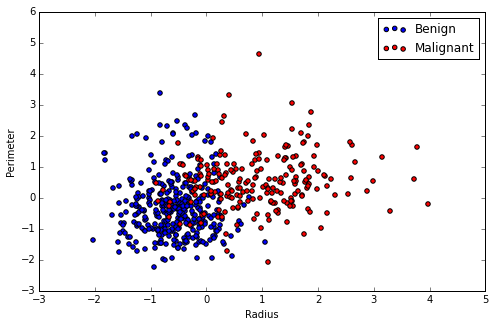

In [8]:
plt.figure(figsize=(8, 5))
plt.scatter(Xauto[yTransformed==0, 0], Xauto[yTransformed==0, 1], edgecolors='black', color = 'b', label='Benign')
plt.scatter(Xauto[yTransformed==1, 0], Xauto[yTransformed==1, 1], edgecolors='black', color = 'r', label='Malignant')
plt.xlabel("Radius")
plt.ylabel("Perimeter")
plt.legend()
plt.show()

We can also plot the distribution of the samples that belong to each distinct class given a specific feature i.e. radius

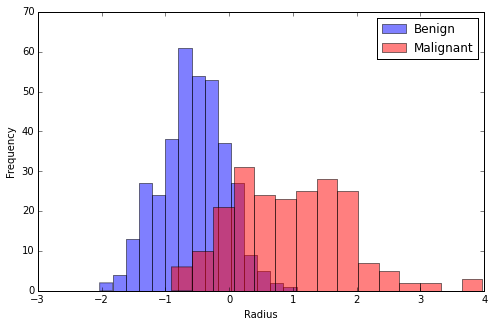

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(Xauto[yTransformed==0,0], color='b', alpha=.5, label='Benign', bins=15)
plt.hist(Xauto[yTransformed==1,0], color='r', alpha=.5, label='Malignant', bins=15)
plt.xlabel("Radius")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Training and testing a classifier

Training and testing a classification model on the same dataset is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data (poor generalisation). <br/> 

To use different datasets for training and testing, we need to split the breast cancer dataset into two disjoint sets: train and test (**Holdout method**). <br/> 

In [10]:
XTrain, XTest, yTrain, yTest = cv.train_test_split(Xauto, yTransformed, test_size= 0.3, random_state=5)

XTrain and yTrain are the two arrays you use to train your model. XTest and yTest are the two arrays that you use to evaluate your model. By default, scikit-learn splits the data so that 25% of it is used for testing, but you can also specify the proportion of data you want to use for training and testing (in this case, 30% is used for testing).

You can check the sizes of the different training and test sets by using the shape attribute:

In [11]:
print "XTrain dimensions:", XTrain.shape
print "yTrain dimensions:", yTrain.shape
print "XTest dimensions:",  XTest.shape
print "yTest dimensions:",  yTest.shape

XTrain dimensions: (398, 30)
yTrain dimensions: (398,)
XTest dimensions: (171, 30)
yTest dimensions: (171,)


## K Nearest Neighbors (KNN)

To build KNN models using scikit-learn, you will be using the `KNeighborsClassifier` function, which allows you to set the value of K using the `n_neighbors` parameter. The optimal choice of the value K is highly data-dependent: in general a larger K suppresses the effects of noise, but makes the classification boundaries less distinct. <br/>

### Uniform weights

We are going to start by trying two predefined random values of K and compare their performance:

In [12]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(XTrain, yTrain)
yPredK3 = knn3.predict(XTest)

print metrics.classification_report(yTest, yPredK3)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredK3), 2)

             precision    recall  f1-score   support

          0       0.96      0.99      0.97       110
          1       0.98      0.92      0.95        61

avg / total       0.97      0.96      0.96       171

Overall Accuracy: 0.96


In [13]:
knn100 = KNeighborsClassifier(n_neighbors=100)
knn100.fit(XTrain, yTrain)
yPredK100 = knn100.predict(XTest)

print metrics.classification_report(yTest, yPredK100)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredK100), 2)

             precision    recall  f1-score   support

          0       0.94      0.99      0.96       110
          1       0.98      0.89      0.93        61

avg / total       0.95      0.95      0.95       171

Overall Accuracy: 0.95


### Visualisation 

We can visualise the classification boundary created by the KNN classifier using the following function. For easier visualisation, only the test samples have been included in the plot. Remember that the decision boundary has been built using the _training_ data! <br/> 

For smaller values of K the decision boundaries present many "creases". In this case the models may suffer from instances of overfitting. 

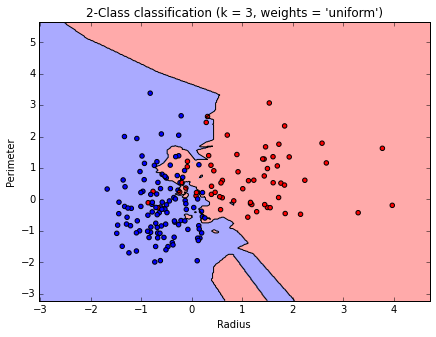

In [14]:
visplots.knnDecisionPlot(XTrain, yTrain, XTest, yTest, n_neighbors= 3, weights="uniform")

We can see that for larger values of K the decision boundaries are less distinct and tend towards linearity. In these cases the boundaries may be too simple and unable to learn thus leading to underfitting.

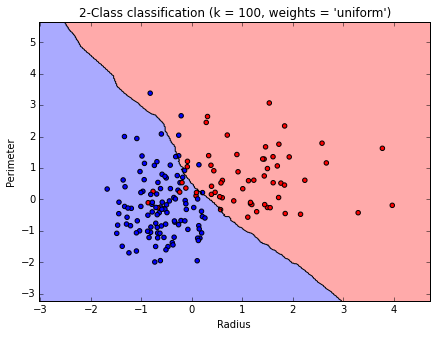

In [15]:
visplots.knnDecisionPlot(XTrain, yTrain, XTest, yTest, n_neighbors= 100, weights="uniform")

### Distance weights

Under some circumstances, it is better to give more importance ("weight" in computing terms) to nearer neighbours. When weights = "distance", weights are assigned to the training data points in a way that is proportional to the inverse of the distance from the query point. In other words, nearer neighbours contribute more to the fit. <br/>

What if we use weights based on distance? Does it improve the overall performance?

In [16]:
knnW3 = KNeighborsClassifier(n_neighbors=3, weights='distance')
knnW3.fit(XTrain, yTrain)
predictedW3 = knnW3.predict(XTest)

print metrics.classification_report(yTest, predictedW3)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, predictedW3), 2)

             precision    recall  f1-score   support

          0       0.96      0.99      0.97       110
          1       0.98      0.92      0.95        61

avg / total       0.97      0.96      0.96       171

Overall Accuracy: 0.96


### Comparison

Rather than trying one-by-one predefined values of K, we can automate this process. The following function plots the accuracies of applying the KNN algorithms with different K values for both uniform and distance weights. Remember that only odd numbers are used for K to avoid ties during majority voting. 

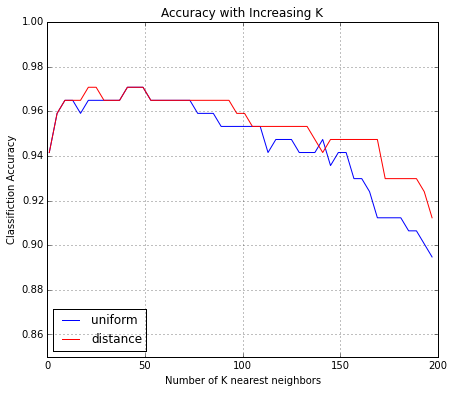

In [17]:
plt.figure(figsize=(7, 6))
visplots.plotaccuracy(XTrain, yTrain, XTest, yTest, 200)

Looking at the plot, you can see that the classifier performs well throughout the selected range of K but when K is too large (K > 100) the accuracy starts to decrease when using uniform weights. When using weights = "distance"
we essentially assign greater weights to neighbours that are closer in distance so that these neighbours contribute more to the fit. This reduces the impact of increasing K on the accuracy and the prediction becomes much less
dramatic.

### Tuning KNN parameters

The sklearn library has a grid search function, `GridSearchCV`, that allows us to search for the optimum
combination of parameters by evaluating models trained with a particular algorithm with all provided parameter combinations. You can use this function to search for a parametisation of the KNN algorithm
that gives a more optimal model.

In [18]:
# We want to use odd numbers of K to avoid ties
n_neighbors = np.arange(1, 50, 2)
weights     = ['uniform','distance']

# GridSearchCV accepts parameter values  only as a dictionary
parameters = [{'n_neighbors': n_neighbors, 'weights': weights}]
grid = GridSearchCV(KNeighborsClassifier(), parameters, cv= 10)
grid.fit(XTrain, yTrain)

print "The best parameters are: n_neighbors=", grid.best_params_['n_neighbors'],"and weight=",grid.best_params_['weights']

The best parameters are: n_neighbors= 3 and weight= uniform


<br/> Let us graphically represent these results using a heatmap:

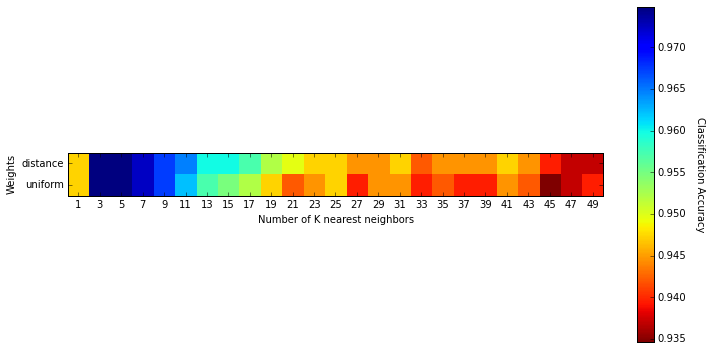

In [19]:
# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict = grid.grid_scores_
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(n_neighbors), len(weights))
scores = np.transpose(scores)

# Make a heatmap with the performance
plt.figure(figsize=(12, 6))
plt.imshow(scores, interpolation='nearest', origin='higher', cmap=plt.cm.get_cmap('jet_r'))
plt.xticks(np.arange(len(n_neighbors)), n_neighbors)
plt.yticks(np.arange(len(weights)), weights)
plt.xlabel('Number of K nearest neighbors')
plt.ylabel('Weights')

cbar = plt.colorbar()
cbar.set_label('Classification Accuracy', rotation=270, labelpad=20)

plt.show()

When evaluating the resulting model it is important to do it on held-out samples that were not seen during the grid search process (XTest). <br/> So, we are testing our independent XTest dataset using the optimised model:

In [20]:
knn = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'], weights = grid.best_params_['weights'])
knn.fit(XTrain, yTrain)
yPredKnn = knn3.predict(XTest)

print metrics.classification_report(yTest, yPredKnn)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredKnn), 2)

             precision    recall  f1-score   support

          0       0.96      0.99      0.97       110
          1       0.98      0.92      0.95        61

avg / total       0.97      0.96      0.96       171

Overall Accuracy: 0.96


Randomized search on hyperparameters. Unlike `GridSearchCV`, `RandomizedSearchCV` does not exhaustively try all the parameter settings. Instead, it samples a fixed number of parameter settings from the specified distributions. The number of parameter settings that are tried is given by `n_iter`. If all parameters are presented as a list, sampling without replacement is performed. If at least one parameter is given as a distribution, sampling with replacement is used. You should use continuous distributions for continuous parameters.

The best parameters are: n_neighbors= 7


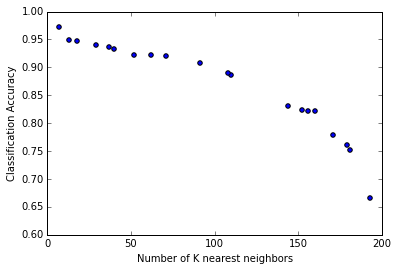

In [21]:
param_dist = {'n_neighbors': randint(1,200)}
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist, n_iter=20)
random_search.fit(XTrain, yTrain)

print "The best parameters are: n_neighbors=", random_search.best_params_['n_neighbors']

neig = [score_tuple[0]['n_neighbors'] for score_tuple in random_search.grid_scores_]
res = [score_tuple[1] for score_tuple in random_search.grid_scores_]
plt.scatter(neig, res)
plt.xlabel('Number of K nearest neighbors')
plt.ylabel('Classification Accuracy')
plt.xlim(0,200)
plt.show()

## Support Vector Machines (SVMs)

SVMs attempt to build a decision boundary that accurately separates the samples of different classes by *maximizing* the margin between them.

### Linear SVMs

The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C tolerates training misclassifications and allows softer margins, while for high C the misclassifications become more significant leading to hard-margin SVMs and potentially cases of overfitting. 

In this example, we will use linear SVMs with the default value for C

In [22]:
# Default C parameter
linearSVM = SVC(kernel='linear')
linearSVM.fit(XTrain, yTrain)
yPredLinear = linearSVM.predict(XTest)

print metrics.classification_report(yTest, yPredLinear)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredLinear),2)

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       110
          1       0.98      0.97      0.98        61

avg / total       0.98      0.98      0.98       171

Overall Accuracy: 0.98


We can visualise the classification boundary created by the linear SVM using the following function. For easier visualisation, only the test samples have been included in the plot. And remember that the decision boundary has been built using the _training_ data!

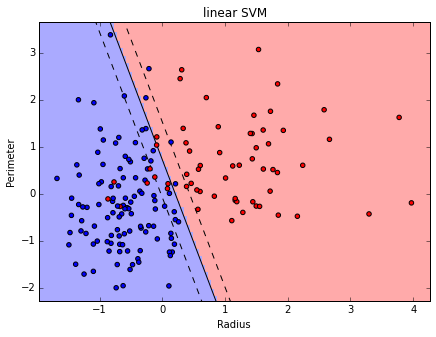

In [23]:
visplots.svmDecisionPlot(XTrain, yTrain, XTest, yTest, 'linear')

### Non-linear SVMs

In addition to C, which is common for all types of SVM, the gamma parameter in the RBF kernel controls the nonlinearity of the SVM bounaries. The larger the gamma, the more nonlinear the boundaries surrounding individual samples. Lower values of gamma lead to broader, more linear boundaries. <br/><br/>  In this example, we will use non-linear SVMs with the default values for C and gamma

In [24]:
# Default C and gamma parameters
rbfSVM = SVC(kernel='rbf', C=1.0, gamma=0.0)
rbfSVM.fit(XTrain, yTrain)
yPredRBF = rbfSVM.predict(XTest)

print metrics.classification_report(yTest, yPredRBF)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredRBF),2)

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       110
          1       0.98      0.97      0.98        61

avg / total       0.98      0.98      0.98       171

Overall Accuracy: 0.98


We can visualise the classification boundary created by the RBF SVM using the following function. Once more, for easier visualisation, only the test samples have been included in the plot. And remember that the decision boundary has been built using the _training_ data!

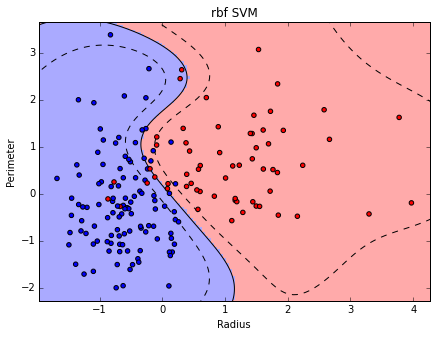

In [25]:
visplots.svmDecisionPlot(XTrain, yTrain, XTest, yTest, 'rbf')

### Hyperparameter Tuning

Proper choice of C and gamma is critical for the performance of SVMs. Optimisation (tuning) of the hyperparameters can be achieved by applying a coarse tuning (often followed by a finer-tuning in the "neighborhood" of good parameters)

In [26]:
# Range for gamma and Cost hyperparameters
g_range = 2. ** np.arange(-15, 5, step=2)
C_range = 2. ** np.arange(-5, 15, step=2)

grid = [{'gamma': g_range, 'C': C_range}]

gridcv = GridSearchCV(SVC(), param_grid=grid, cv= cv.KFold(n=XTrain.shape[0], n_folds=5))
gridcv.fit(XTrain, yTrain)

bestG = np.log2(gridcv.best_params_['gamma']);
bestC = np.log2(gridcv.best_params_['C']);

print "The best parameters are: gamma=", bestG, " and Cost=", bestC

The best parameters are: gamma= -9.0  and Cost= 3.0


Plot the results of the grid search using a heatmap

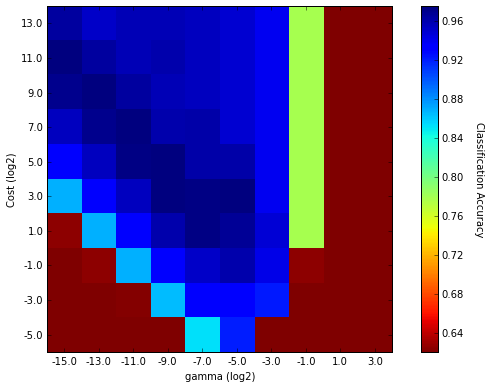

In [27]:
# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict = gridcv.grid_scores_
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(C_range), len(g_range))

# Make a heatmap with the performance
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', origin='higher', cmap=plt.cm.get_cmap('jet_r'))
plt.xlabel('gamma (log2)')
plt.ylabel('Cost (log2)')
plt.xticks(np.arange(len(g_range)), np.log2(g_range))
plt.yticks(np.arange(len(C_range)), np.log2(C_range))

cbar = plt.colorbar()
cbar.set_label('Classification Accuracy', rotation=270, labelpad=20)

plt.show()

Finally, testing with the optimised model (best hyperparameters):

In [28]:
rbfSVM = SVC(kernel='rbf', C=gridcv.best_params_['C'], gamma=gridcv.best_params_['gamma'])
rbfSVM.fit(XTrain, yTrain)

predictions = rbfSVM.predict(XTest) 

print metrics.classification_report(yTest, predictions)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, predictions),2)

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       110
          1       1.00      0.97      0.98        61

avg / total       0.99      0.99      0.99       171

Overall Accuracy: 0.99


## Logistic Regression

Logistic regression predicts the probability that a sample belongs to a class based on the values of the input variables, based on a linear model. In the case of classification, we can use this to then assign the sample to the most likely class.

In [29]:
l_regression = LogisticRegression()
l_regression.fit(XTrain, yTrain)
net_prediction = l_regression.predict(XTest)

print metrics.classification_report(yTest, net_prediction)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, net_prediction),2)

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       110
          1       0.98      0.97      0.98        61

avg / total       0.98      0.98      0.98       171

Overall Accuracy: 0.98


We can visualise the classification boundary created by the logistic regression model using the built in visualisation function `logregDecisionPlot`. As with the above examples, only the test samples have been included in the plot. And remember that the decision boundary has been built using the _training_ data!

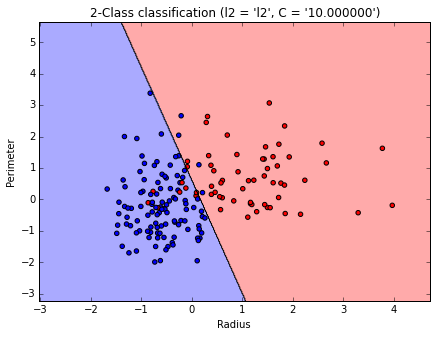

In [30]:
visplots.logregDecisionPlot(XTrain, yTrain, XTest, yTest)

Two hyperparameters that are often tuned for logistic regression models are the norm used in penalisation (`penalty`), which can be either `l1` or `l2` (default `l2`) and the inverse of regularisation strength, `C` (default `1.0`). 



In [31]:
# Range for gamma and Cost hyperparameters
pen = ['l1','l2']
C_range = 2. ** np.arange(-5, 15, step=2)

grid = [{'C': C_range, 'penalty': pen}]

gridcv = GridSearchCV(LogisticRegression(), param_grid=grid, cv= cv.KFold(n=XTrain.shape[0], n_folds=5))
gridcv.fit(XTrain, yTrain)

best_c = gridcv.best_params_['C']
best_penalty = gridcv.best_params_['penalty']

print "The best parameters are: cost=", best_c, " and penalty=", best_penalty

The best parameters are: cost= 0.5  and penalty= l2


Now try these out to see how the performance metrics are affected.

In [32]:
l_regression = LogisticRegression(C=0.5, penalty='l2')
l_regression.fit(XTrain, yTrain)
net_prediction = l_regression.predict(XTest)

print metrics.classification_report(yTest, net_prediction)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, net_prediction),2)

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       110
          1       1.00      0.97      0.98        61

avg / total       0.99      0.99      0.99       171

Overall Accuracy: 0.99


Plot the results of the grid search with a heatmap.

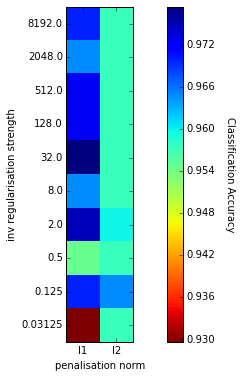

In [33]:
# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict = gridcv.grid_scores_
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(pen), len(C_range))
scores = np.transpose(scores)

# Make a heatmap with the performance
plt.figure(figsize=(12, 6))
plt.imshow(scores, interpolation='nearest', origin='higher', cmap=plt.cm.get_cmap('jet_r'))
plt.xticks(np.arange(len(pen)), pen)
plt.yticks(np.arange(len(C_range)), C_range)
plt.xlabel('penalisation norm')
plt.ylabel('inv regularisation strength')

cbar = plt.colorbar()
cbar.set_label('Classification Accuracy', rotation=270, labelpad=20)

plt.show()

For more details on cross-validating and tuning logistic regression models, see: <br/>
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
and <br/>
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## Neural Networks

A neural network is a set of connected input-output units. During training, the connections are assigned different weights. This allows the classification function to take on highly complex "shapes" (equivalent to complicated mathematical expressions that go beyond the linear or polynomial models of logistic regression). This might also mean that the resulting model is difficult to interpret and map to domain knowledge. (NB. even though you might think of the second layer of a neural network as just a logistic regression model, the non-linear transformation in the hidden units gives the input to output mapping a non-linear decision boundary.)


In [34]:
nnet = multilayer_perceptron.MultilayerPerceptronClassifier(activation='logistic',
                                                            hidden_layer_sizes=2, learning_rate_init=.5)
nnet.fit(XTrain, yTrain)
net_prediction = nnet.predict(XTest)

print metrics.classification_report(yTest, net_prediction)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, net_prediction),2)

             precision    recall  f1-score   support

          0       0.98      0.98      0.98       110
          1       0.97      0.97      0.97        61

avg / total       0.98      0.98      0.98       171

Overall Accuracy: 0.98


We can visualise the classification boundary created by the neural network using the built in visualisation function `nnDecisionPlot`. As with the above examples, only the test samples have been included in the plot. And remember that the decision boundary has been built using the _training_ data!

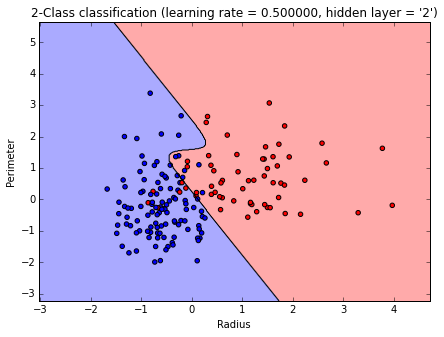

In [35]:
visplots.nnDecisionPlot(XTrain, yTrain, XTest, yTest, 2, .5)

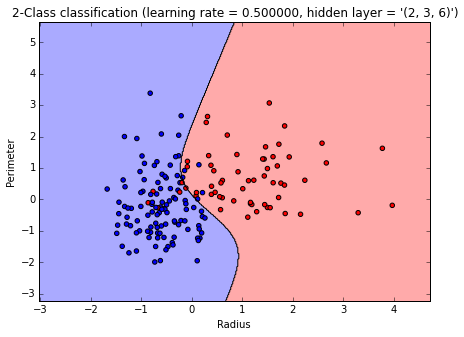

In [36]:
visplots.nnDecisionPlot(XTrain, yTrain, XTest, yTest, (2,3,6), .5)

Neural networks have many hyperparameters, all of which could potentially be tuned, including learning rate, loss function, number of training iterations, number of hidden layers and number of units within each of them, nonlinearity function, and weight initialisation. 

Here's a worked through example which explores the set of parameter configurations with different numbers of hidden layers and units within them (`hidden_layer_sizes`), and learning rates (`learning_rate_init`).

Note the syntax to specify the number of hidden layers and units with them. If a tuple is given, each value in the tuple stands for the number of units in a layer, e.g. the tuple `(2,3,4)` would mean a network with two units in the first layer, three units in the second, and four in the third. If a single value is given, then there is only one hidden layer, and the value stands for the number of units in this layer.

In [37]:
# Range for gamma and Cost hyperparameters
layer_size_range = [(3,2),(10,10),(2,2,2),10,5] # different networks shapes
learning_rate_range = np.linspace(.1,1,3)

grid = [{'hidden_layer_sizes': layer_size_range, 'learning_rate_init': learning_rate_range}]

gridcv = GridSearchCV(multilayer_perceptron.MultilayerPerceptronClassifier(), 
                      param_grid=grid, cv= cv.KFold(n=XTrain.shape[0], n_folds=5))
gridcv.fit(XTrain, yTrain)

best_size = gridcv.best_params_['hidden_layer_sizes']
best_best_lr = gridcv.best_params_['learning_rate_init']

print "The best parameters are: hidden_layer_sizes=", best_size, " and learning_rate_init=", best_best_lr

The best parameters are: hidden_layer_sizes= 5  and learning_rate_init= 0.1


Now try these out to see how the performance metrics are affected.

In [38]:
nnet = multilayer_perceptron.MultilayerPerceptronClassifier(hidden_layer_sizes=best_size, learning_rate_init=best_best_lr)
nnet.fit(XTrain, yTrain)
net_prediction = nnet.predict(XTest)

print metrics.classification_report(yTest, net_prediction)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, net_prediction),2)

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       110
          1       0.98      0.95      0.97        61

avg / total       0.98      0.98      0.98       171

Overall Accuracy: 0.98


Plot the results of the grid search using a heatmap.

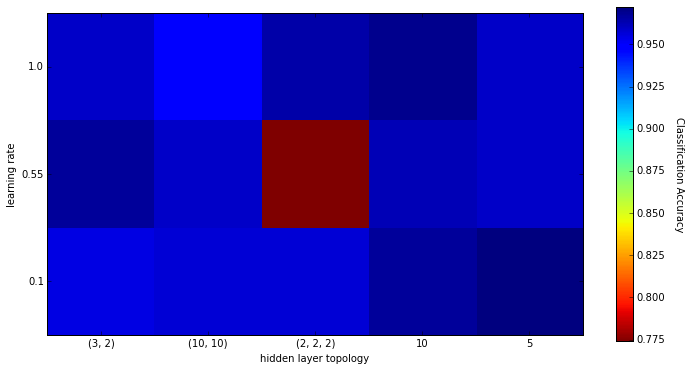

In [39]:
# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict = gridcv.grid_scores_
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(layer_size_range), len(learning_rate_range))
scores = np.transpose(scores)

# Make a heatmap with the performance
plt.figure(figsize=(12, 6))
plt.imshow(scores, interpolation='nearest', origin='higher', cmap=plt.cm.get_cmap('jet_r'))
plt.xticks(np.arange(len(layer_size_range)), layer_size_range)
plt.yticks(np.arange(len(learning_rate_range)), learning_rate_range)
plt.xlabel('hidden layer topology')
plt.ylabel('learning rate')

cbar = plt.colorbar()
cbar.set_label('Classification Accuracy', rotation=270, labelpad=20)

plt.show()

- *So, what is your best technique and why?*